# Binarize MNIST

Converts the original MNIST dataset to a binarized black and white version thresholded by a chosen intensity 0-255.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from model import DCGAN
%matplotlib inline
NPY_DIR = 'npy'

/home/mitchgu/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def show(images):
    for img in images:
        plt.figure()
        plt.imshow(img[:,:,0], cmap="Greys_r")

## Load original dataset

In [3]:
data_dir = "./data/mnist"

# Load both train and test images and labels into a numpy byte array
with open(os.path.join(data_dir, 'train-images-idx3-ubyte'), 'r') as fd:
    trX_load = np.fromfile(file=fd, dtype=np.uint8)
    
with open(os.path.join(data_dir, 'train-labels-idx1-ubyte'), 'r') as fd:
    trY_load = np.fromfile(file=fd, dtype=np.uint8)
    
with open(os.path.join(data_dir, 't10k-images-idx3-ubyte'), 'r') as fd:
    teX_load = np.fromfile(file=fd, dtype=np.uint8)
    
with open(os.path.join(data_dir, 't10k-labels-idx1-ubyte'), 'r') as fd:
    teY_load = np.fromfile(file=fd, dtype=np.uint8)


# Cut off the first header bytes and reshape the rest into images
trX = trX_load[16:].reshape((60000,28,28,1)).copy()
trY = trY_load[8:].reshape((60000))
teX = teX_load[16:].reshape((10000,28,28,1)).copy()
teY = teY_load[8:].reshape((10000))

## Choose threshold

In [4]:
th=100

In [5]:
def threshold(inp, th):
    return 255*(inp > th).astype(np.uint8)

## Threshold the entire dataset and save into new IDX files

In [6]:
trX_th = threshold(trX, th)
teX_th = threshold(teX, th)

In [7]:
trX_load[16:] = trX_th.flatten()
teX_load[16:] = teX_th.flatten()

trX_load.tofile(os.path.join(data_dir, "th-train-images-idx3-ubyte"))
teX_load.tofile(os.path.join(data_dir, "th-t10k-images-idx3-ubyte"))

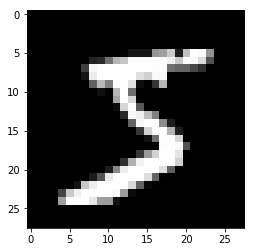

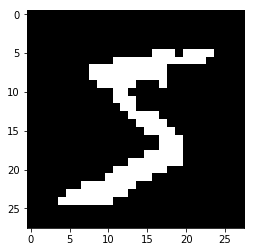

In [8]:
show(trX[:1])
show(trX_th[:1])

# Generate some sample real and fake batches

In [9]:
np.random.seed(42)

# Dump 64 real thresholded images into samples1.npy
trX_th[0:64].dump('npy/samples1.npy')
trY[0:64].dump('npy/samples1_y.npy')

# Dump uniform random images into samples2.npy
rand = np.random.choice(256, (64,28,28,1)).astype(np.uint8)
rand.dump('npy/samples2.npy')
rand_y = np.random.choice(10, 64).astype(np.uint8)
rand_y.dump('npy/samples2_y.npy')

# Dump 64 real thresholded images with quadrant removed into samples1.npy
chopped = trX_th[0:64].copy()
chopped[:,7:21,7:21,:] = 0
chopped.dump('npy/samples3.npy')
trY[0:64].dump('npy/samples3_y.npy')

# Dump black images into samples4.npy
black = np.zeros((64,28,28,1)).astype(np.uint8)
black.dump('npy/samples4.npy')
black_y = np.random.choice(10, 64).astype(np.uint8)
black_y.dump('npy/samples4_y.npy')

# Run them through the policy net (discriminator)

In [10]:
sess = tf.Session()
# Create DCGAN model
dcgan = DCGAN(sess)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/mnist_64_28_28/DCGAN.model-27002
 [*] Success to read DCGAN.model-27002


In [11]:
for samples_fname in ["samples1", "samples2", "samples3", "samples4"]:
    # Load samples from numpy file
    samples = np.load(os.path.join(NPY_DIR, samples_fname + ".npy"))
    samples_y = np.load(os.path.join(NPY_DIR, samples_fname + "_y.npy"))

    # Samples needs to be shape (64, 28, 28, 1)
    # labels need to be in shape (64)
    v, grad = dcgan.run_policy(samples, samples_y) # returns real/fake value and gradients

    # Print mean value for 64 samples
    print("Mean real/fake value for {}: {}".format(samples_fname, np.mean(v)))
    # Dump the gradients to a file (64, 28, 28, 1)
    grad.dump(os.path.join(NPY_DIR, samples_fname + "_grad.npy"))

Mean real/fake value for samples1: 0.6104665994644165
Mean real/fake value for samples2: 0.5223574638366699
Mean real/fake value for samples3: 0.5426047444343567
Mean real/fake value for samples4: 0.30376964807510376


# Visualize some gradients

[0 6]


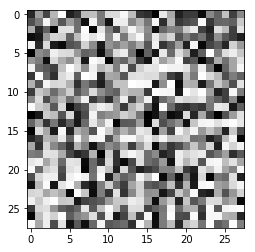

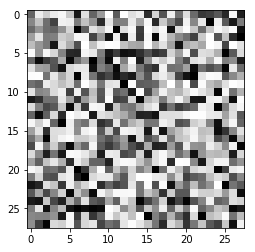

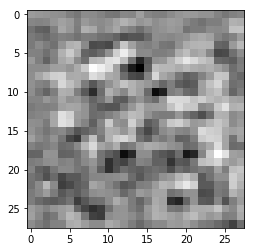

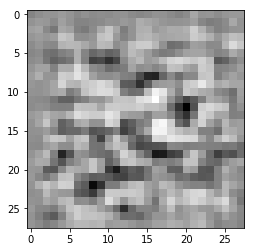

In [12]:
grad = np.load("npy/samples2_grad.npy")
print(rand_y[:2])
show(rand[:2])
show(grad[:2])

[5 0 4 1]


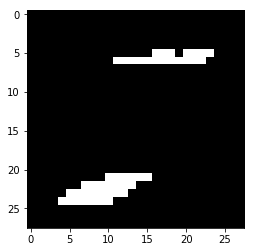

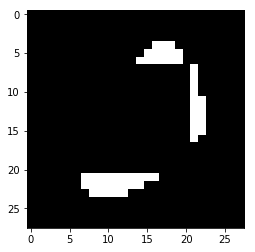

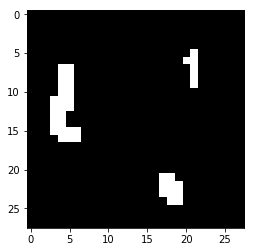

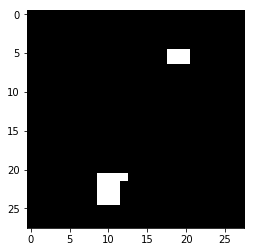

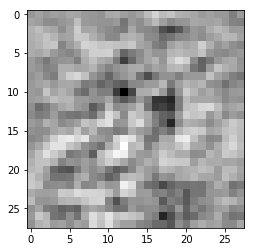

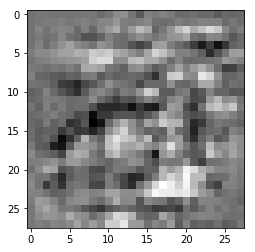

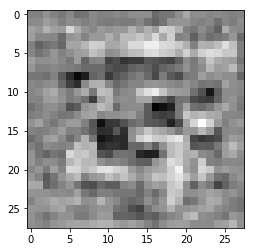

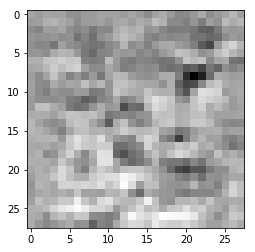

In [13]:
grad = np.load("npy/samples3_grad.npy")
n = 4
print(trY[:n])
show(chopped[:n])
show(grad[:n])